/home/dciechan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.



ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +2e+07  1e+00  1e-02  1e+00  3e+03    ---    ---    1  1  - |  -  - 
 1  +1.367e+04  +1.395e+04  +9e+06  9e-01  5e-03  3e+02  1e+03  0.6529  1e-01   1  1  1 |  0  0
 2  +1.645e+04  +1.651e+04  +8e+05  4e-01  5e-04  6e+01  1e+02  0.9346  3e-02   1  0  1 |  0  0
 3  +3.238e+04  +3.240e+04  +3e+05  2e-01  2e-04  2e+01  5e+01  0.6825  7e-02   1  0  0 |  0  0
 4  +4.713e+04  +4.714e+04  +1e+05  5e-02  5e-05  8e+00  2e+01  0.6991  3e-02   1  0  1 |  0  0
 5  +5.900e+04  +5.901e+04  +3e+04  2e-02  2e-05  3e+00  5e+00  0.7016  6e-02   1  1  1 |  0  0
 6  +6.339e+04  +6.340e+04  +1e+04  8e-03  7e-06  2e+00  2e+00  0.6602  1e-01   1  0  1 |  0  0
 7  +6.531e+04  +6.532e+04  +6e+03  3e-03  3e-06  7e-01  9e-01  0.6638  1e-01   1  0  1 |  0  0
 8  +6.601e+04  +6.601e+04  +3e+03  1e-03  1e-

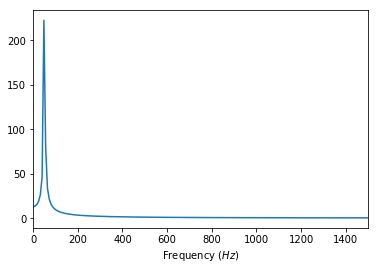

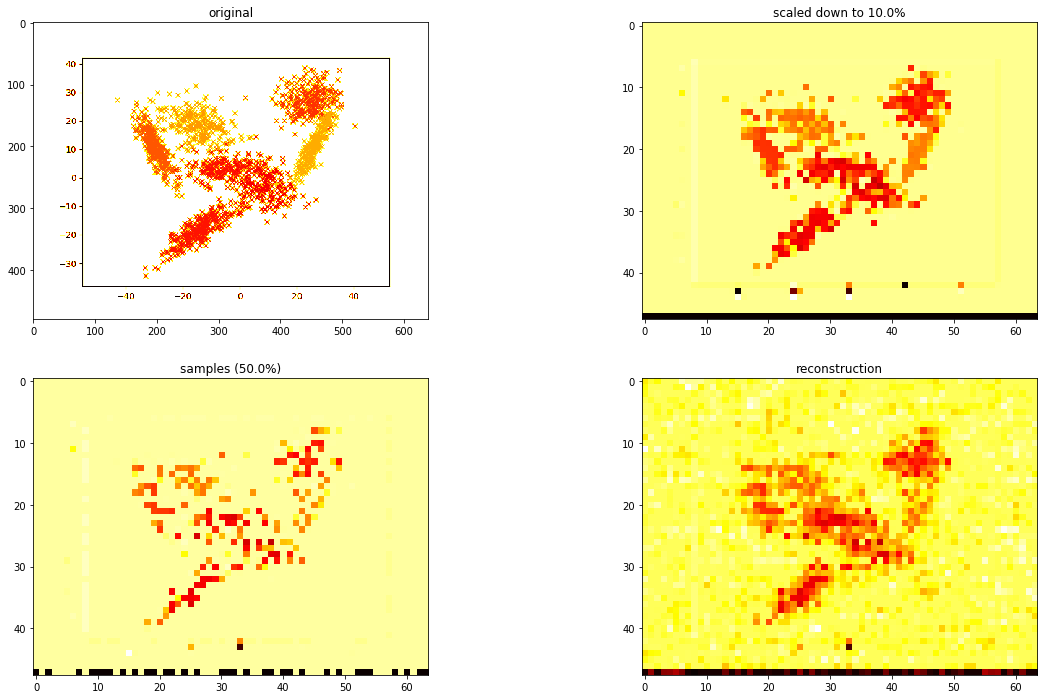

In [10]:
# http://www.pyrunner.com/weblog/2016/05/26/compressed-sensing-python/
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import cvxpy as cvx

img_file = 'test.png'
img_downscale = 0.1
sample_percentage = 0.5


def dct2(x):
    return spfft.dct(spfft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)


def idct2(x):
    return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)


# image reconstruction with compressive sensing
if __name__ == '__main__':
    # read original image and downsize for speed
    original_image = spimg.imread(img_file, flatten=True, mode='L')  # read in grayscale
    scaled_down_image = spimg.zoom(original_image, img_downscale)
    ny, nx = scaled_down_image.shape

    # extract small sample of signal
    k = round(nx * ny * sample_percentage)
    ri = np.random.choice(nx * ny, k, replace=False)  # random sample of indices
    b = scaled_down_image.T.flat[ri]
    b = np.expand_dims(b, axis=1)

    # create dct matrix operator using kron (memory errors for large ny*nx)
    A = np.kron(
        spfft.idct(np.identity(nx), norm='ortho', axis=0),
        spfft.idct(np.identity(ny), norm='ortho', axis=0)
    )
    A = A[ri, :]  # same as phi times kron

    # do L1 optimization
    vx = cvx.Variable(nx * ny)
    objective = cvx.Minimize(cvx.norm(vx, 1))
    constraints = [A * vx == b]
    prob = cvx.Problem(objective, constraints)
    result = prob.solve(verbose=True)
    Xat2 = np.array(vx.value).squeeze()

    # reconstruct signal
    Xat = Xat2.reshape(nx, ny).T  # stack columns
    Xa = idct2(Xat)

    # confirm solution
    if not np.allclose(scaled_down_image.T.flat[ri], Xa.T.flat[ri]):
        print('Warning: values at sample indices don\'t match original.')

    # create images of mask (for visualization)
    mask = np.zeros(scaled_down_image.shape)
    mask.T.flat[ri] = 255
    Xm = 255 * np.ones(scaled_down_image.shape)
    Xm.T.flat[ri] = scaled_down_image.T.flat[ri]

    # display the result

    f, ax = plt.subplots(2, 2, figsize=(20, 12))

    ax[0, 0].imshow(original_image, cmap='hot', interpolation='none')
    ax[0, 0].set_title('original')

    ax[0, 1].imshow(scaled_down_image, cmap='hot', interpolation='none')
    ax[0, 1].set_title('scaled down to {0}%'.format(img_downscale*100))

    ax[1, 0].imshow(Xm, cmap='hot', interpolation='none')
    ax[1, 0].set_title('samples ({0}%)'.format(sample_percentage*100))

    ax[1, 1].imshow(Xa, cmap='hot', interpolation='none')
    ax[1, 1].set_title('reconstruction')
    plt.show()